<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#data-preprocessing" data-toc-modified-id="data-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>data preprocessing</a></span></li><li><span><a href="#baseline" data-toc-modified-id="baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>baseline</a></span></li><li><span><a href="#fit-LSTM" data-toc-modified-id="fit-LSTM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>fit LSTM</a></span><ul class="toc-item"><li><span><a href="#lstm-model" data-toc-modified-id="lstm-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>lstm model</a></span></li><li><span><a href="#evaluation-functions" data-toc-modified-id="evaluation-functions-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>evaluation functions</a></span></li><li><span><a href="#baseline-result" data-toc-modified-id="baseline-result-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>baseline result</a></span></li><li><span><a href="#hyperpameter-tunning" data-toc-modified-id="hyperpameter-tunning-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>hyperpameter tunning</a></span></li><li><span><a href="#test-score" data-toc-modified-id="test-score-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>test score</a></span></li></ul></li></ul></div>

In [75]:
import numpy as np
import pandas as pd
import os
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
#from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
%matplotlib inline

In [76]:
df_elec = pd.read_csv('data/time-series-datasets/Electric_Production.csv')
df_stock = pd.read_csv('data/NSE-TATAGLOBAL11.csv')

In [78]:
#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [79]:
print(df_stock.shape)
df_stock.head()

(1235, 8)


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-10-08,208.00,222.25,206.85,216.00,215.15,4642146.0,10062.83
1,2018-10-05,217.00,218.60,205.90,210.25,209.20,3519515.0,7407.06
2,2018-10-04,223.50,227.80,216.15,217.25,218.20,1728786.0,3815.79
3,2018-10-03,230.00,237.50,225.75,226.45,227.60,1708590.0,3960.27
4,2018-10-01,234.55,234.60,221.05,230.30,230.90,1534749.0,3486.05


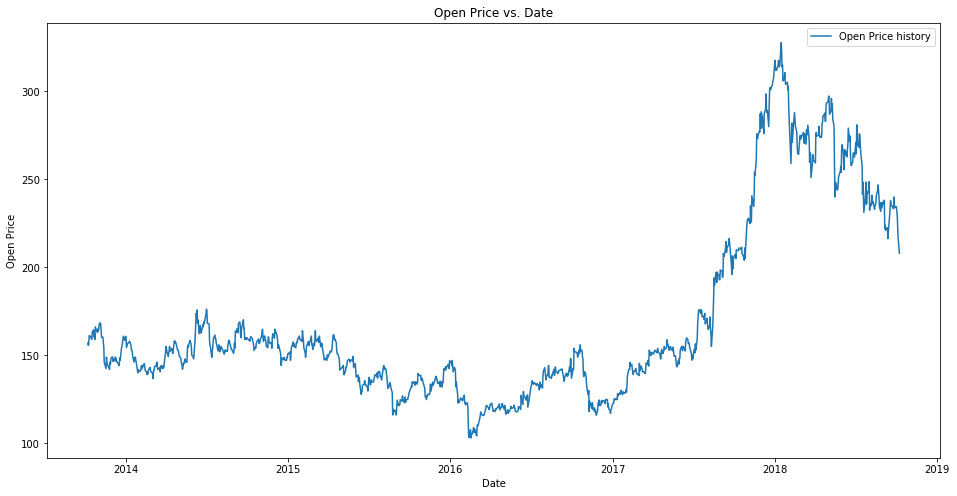

In [83]:
#setting index as date
df_stock['Date'] = pd.to_datetime(df_stock.Date,format='%Y-%m-%d')
df_stock.index = df_stock['Date']

#plot
plt.figure(figsize=(16,8))
plt.plot(df_stock['Open'], label='Open Price history')
plt.title("Open Price vs. Date")
plt.ylabel("Open Price")
plt.xlabel("Date")
plt.legend()

## data preprocessing

In [110]:
#reference:https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/
data = df_stock.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_stock)),columns=['Date', 'Open'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Open'][i] = data['Open'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train dev and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:1111,:]
test = dataset[1111:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


## baseline

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting valid values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
open_price = model.predict(X_test)
open_price = scaler.inverse_transform(open_price)

In [54]:
rmse=np.sqrt(np.mean(np.power((valid-open_price),2)))
smape = np.mean(abs(open_price - valid) * 1.0 / (abs(open_price) + abs(valid)) * 2)
print(rmse)
print(smape)

12.70119513402331
0.07277530473956537


## fit LSTM 

### lstm model

In [55]:
def lstm(x_train,y_train,num_units=50,dropout_rate=0):
    model = Sequential()
    model.add(LSTM(units=num_units, return_sequences=True, input_shape=(x_train.shape[1],1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=num_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    X_test = []
    for i in range(60,inputs.shape[0]):
        X_test.append(inputs[i-60:i,0])
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
    open_price = model.predict(X_test)
    open_price = scaler.inverse_transform(open_price)
    return open_price

### evaluation functions

In [95]:
def eval_fc(pred,valid):
    rmse=np.sqrt(np.mean(np.power((valid-pred),2)))
    smape = np.mean(abs(pred - valid) * 1.0 / (abs(pred) + abs(valid)) * 2)
    return smape,rmse

### hyperpameter tunning

In [56]:
# parameters
hidden_size = [64,128,256,512]
dropout_rates = [0.1,0.2,0.3]

In [57]:
res_dic={}
for num_units in hidden_size:
    for dropout_rate in dropout_rates:
        open_price=lstm(x_train,y_train,num_units,dropout_rate)
        res=eval_fc(open_price,valid)
        res_dic[num_units,dropout_rate]=res
        print(res_dic)
        

Epoch 1/1
 - 71s - loss: 0.0054
{(64, 0.1): (0.06303164540463375, 11.828477640848897)}
Epoch 1/1
 - 73s - loss: 0.0054
{(64, 0.1): (0.06303164540463375, 11.828477640848897), (64, 0.2): (0.056358258743088335, 11.555184219399294)}
Epoch 1/1
 - 73s - loss: 0.0083
{(64, 0.1): (0.06303164540463375, 11.828477640848897), (64, 0.2): (0.056358258743088335, 11.555184219399294), (64, 0.3): (0.08647291796924189, 14.788203996626308)}
Epoch 1/1
 - 78s - loss: 0.0040
{(64, 0.1): (0.06303164540463375, 11.828477640848897), (64, 0.2): (0.056358258743088335, 11.555184219399294), (64, 0.3): (0.08647291796924189, 14.788203996626308), (128, 0.1): (0.06831732705776405, 12.232339933031408)}
Epoch 1/1
 - 82s - loss: 0.0062
{(64, 0.1): (0.06303164540463375, 11.828477640848897), (64, 0.2): (0.056358258743088335, 11.555184219399294), (64, 0.3): (0.08647291796924189, 14.788203996626308), (128, 0.1): (0.06831732705776405, 12.232339933031408), (128, 0.2): (0.051522374038277426, 10.487144394423243)}
Epoch 1/1
 - 107s

In [58]:
res_dic

{(64, 0.1): (0.06303164540463375, 11.828477640848897),
 (64, 0.2): (0.056358258743088335, 11.555184219399294),
 (64, 0.3): (0.08647291796924189, 14.788203996626308),
 (128, 0.1): (0.06831732705776405, 12.232339933031408),
 (128, 0.2): (0.051522374038277426, 10.487144394423243),
 (128, 0.3): (0.0693727430112038, 12.440686212568409),
 (256, 0.1): (0.08817788364745155, 15.133907001344765),
 (256, 0.2): (0.07965521484783197, 13.837444202182287),
 (256, 0.3): (0.053170782283031744, 11.714067686899835),
 (512, 0.1): (0.09093835852006414, 15.597605140252877),
 (512, 0.2): (0.09489799178431282, 16.271484067750585),
 (512, 0.3): (0.09005612402455489, 15.638269845726196)}

In [60]:
df_res = pd.DataFrame(res_dic,index=['smape','rmse'])
df_res=df_res.T
df_res

smape       rmse
64  0.1  0.063032  11.828478
    0.2  0.056358  11.555184
    0.3  0.086473  14.788204
128 0.1  0.068317  12.232340
    0.2  0.051522  10.487144
    0.3  0.069373  12.440686
256 0.1  0.088178  15.133907
    0.2  0.079655  13.837444
    0.3  0.053171  11.714068
512 0.1  0.090938  15.597605
    0.2  0.094898  16.271484
    0.3  0.090056  15.638270

The best hyperparameter setting: hidden_size = 128, dropout_rate = 0.2

### test score

In [108]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=128))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
    
    
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
open_price = model.predict(X_test)
open_price = scaler.inverse_transform(open_price)


Epoch 1/1
 - 80s - loss: 0.0013


(Open           0.063374
 Predictions    0.008340
 dtype: float64, Open           17.408399
 Predictions     2.496570
 dtype: float64)

In [111]:
eval_fc(open_price,test)

(0.06337439864655942, 17.408398803222177)

In [121]:
open_price.reshape(-1)

array([255.51094, 257.12762, 257.78076, 257.53683, 257.0346 , 256.53952,
       257.67908, 259.2159 , 261.2907 , 263.1022 , 264.76752, 265.11542,
       264.92914, 266.38483, 268.28268, 270.03384, 272.02985, 272.78314,
       271.84744, 270.84116, 271.3854 , 271.1332 , 271.32117, 269.97644,
       267.55063, 260.76288, 250.7748 , 242.38953, 237.23148, 233.57726,
       231.2719 , 230.43771, 231.17969, 232.57698, 234.39697, 236.49174,
       237.5907 , 240.554  , 244.05704, 246.12387, 245.42525, 245.24019,
       246.0364 , 246.41615, 246.93927, 246.8562 , 247.38315, 248.54245,
       251.46852, 252.95586, 254.21684, 253.01894, 250.12547, 247.19049,
       245.26962, 245.02158, 245.50339, 245.76675, 245.84499, 247.41226,
       247.93864, 251.13364, 253.90826, 254.5017 , 253.88507, 254.39806,
       254.98087, 254.6405 , 253.01877, 249.93028, 243.87267, 239.32579,
       234.62286, 229.30074, 226.3237 , 225.7945 , 227.15242, 226.56291,
       226.35904, 226.82365, 227.3788 , 228.85225, 

In [122]:
np.save('lstm_stock',open_price)

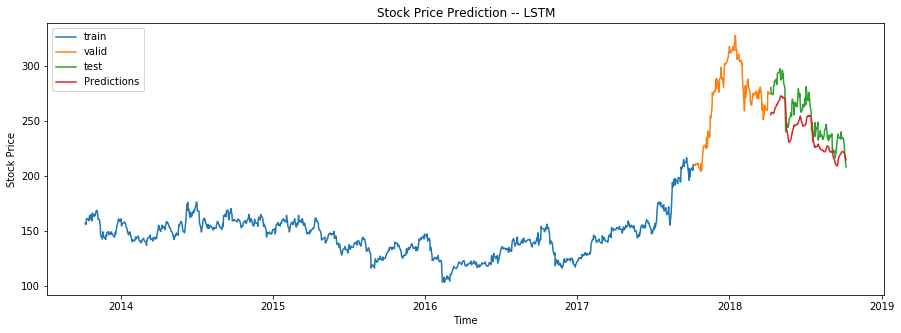

<Figure size 1440x720 with 0 Axes>

In [123]:
# best plot
plt.figure(figsize = (15,5))
train = new_data[:987]
valid = new_data[987:1111]
test = new_data[1111:]
test['Predictions'] = open_price
# plt.plot(train['Open'])
# plt.plot(valid[['Open','Predictions']])
plt.plot(train.Open,label='train')
plt.plot(valid.Open,label='valid')
plt.plot(test.Open,label='test')
plt.plot(test.Predictions)
plt.title('Stock Price Prediction -- LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.savefig('stock_lstm')